# MLP from scratch

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt

In [ ]:
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root = "../data", train = True, transform=trans, download=True
)

mnist_test = torchvision.datasets.FashionMNIST(
    root = "../data", train = False, transform=trans, download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
print(len(mnist_train))
print(len(mnist_test))
print(mnist_train[0][0].shape)

60000
10000
torch.Size([1, 28, 28])


In [ ]:
def get_fmnist_labels(labels) : 
  text_labels = ["tshirt", "trouser", "pullover", "dress", "coat",
                 "sandal", "shirt", "sneaker", "bag", "ankle boot"]
  return [text_labels[int(i)] for i in labels]

## Visualizing Part of the Data

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5) :

  FIGSIZE = (num_cols*scale, num_rows*scale)
  fig, axes = plt.subplots(num_rows, num_cols, figsize=FIGSIZE)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)) :
    if torch.is_tensor(img) :
      ax.imshow(img.numpy())
    else : 
      ax.imshow(img)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles : 
      ax.set_title(titles[i])
  fig.tight_layout()
  return axes

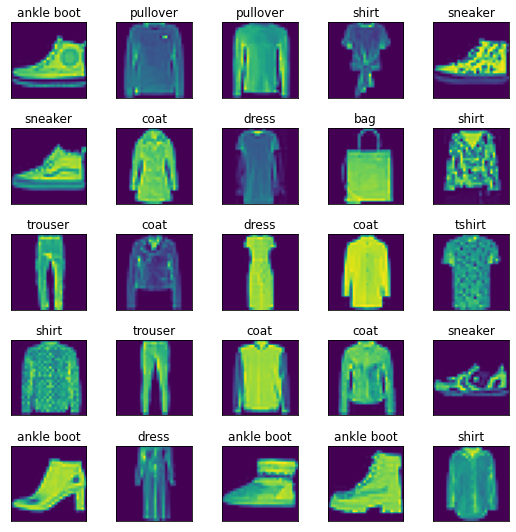

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=25, shuffle=True)))
show_images(X.reshape(25, 28, 28), 5, 5, titles=get_fmnist_labels(y))
plt.show()

## Minibatch Reading

In [ ]:
BATCH_SIZE = 256

train_iter = data.DataLoader(mnist_train, BATCH_SIZE, shuffle=True)
test_iter = data.DataLoader(mnist_test, BATCH_SIZE, shuffle=False)

In [ ]:
for (X, y) in train_iter : 
  print(X.shape, y.shape)
  break

torch.Size([256, 1, 28, 28]) torch.Size([256])


## Model

In [ ]:
INPUTS, OUTPUTS = 784, 10
MID_LAYER = 256
BATCH_SIZE = 256

In [ ]:
W1 = nn.Parameter(torch.randn(
    INPUTS, MID_LAYER, requires_grad=True 
)*0.01)
B1 = nn.Parameter(torch.zeros(MID_LAYER, requires_grad=True))

W2 = nn.Parameter(torch.randn(
    MID_LAYER, OUTPUTS, requires_grad=True 
)*0.01)
B2 = nn.Parameter(torch.zeros(OUTPUTS, requires_grad=True))

In [ ]:
params = [W1, B1, W2, B2]

In [ ]:
def relu(X) :
  a = torch.zeros_like(X)
  return torch.max(X, a)

In [ ]:
def net(X) :
  X = X.reshape((-1, INPUTS))
  H1 = relu(X@W1 + B1)
  H2 = H1@W2 + B2
  return H2

In [ ]:
def accuracy(y_hat, y) :
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(torch.LongTensor)==y
  return float(cmp.type(torch.LongTensor).sum())/len(cmp)

In [ ]:
loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
NUM_EPOCHS = 20
lr = 0.01

optimizer = torch.optim.SGD(params, lr)

losses = []
accuracies = []
val_accuracies = []
val_losses = []

for epoch in range(NUM_EPOCHS) :
  for f, l in train_iter :
    lo = loss(net(f), l)
    optimizer.zero_grad()
    lo.mean().backward()
    optimizer.step()
  
  with torch.no_grad():
    l_loss = []
    l_acc = []
    for f, l in train_iter :
      y_hat = net(f)
      lo = loss(y_hat, l)
      l_loss.append(lo.mean())
      l_acc.append(accuracy(y_hat, l))
    losses.append(torch.tensor(l_loss).mean())
    accuracies.append(torch.tensor(l_acc).mean())

  with torch.no_grad():
    l_loss = []
    l_acc = []
    for f, l in test_iter :
      y_hat = net(f)
      lo = loss(y_hat, l)
      l_loss.append(lo.mean())
      l_acc.append(accuracy(y_hat, l))
    val_losses.append(torch.tensor(l_loss).mean())
    val_accuracies.append(torch.tensor(l_acc).mean())

  print(f"Epoch : {epoch}, Loss : {losses[epoch]:f}, Val_Loss : {val_losses[epoch]:f},\
  Accuracy : {accuracies[epoch]:f}, Val_Accuracy : {val_accuracies[epoch]:f}")  

Epoch : 0, Loss : 1.863862, Val_Loss : 1.866650,  Accuracy : 0.471892, Val_Accuracy : 0.469043
Epoch : 1, Loss : 1.256233, Val_Loss : 1.262120,  Accuracy : 0.602804, Val_Accuracy : 0.599707
Epoch : 2, Loss : 1.003470, Val_Loss : 1.012610,  Accuracy : 0.659968, Val_Accuracy : 0.647363
Epoch : 3, Loss : 0.879660, Val_Loss : 0.890354,  Accuracy : 0.686564, Val_Accuracy : 0.676660
Epoch : 4, Loss : 0.806301, Val_Loss : 0.818129,  Accuracy : 0.698138, Val_Accuracy : 0.685059
Epoch : 5, Loss : 0.759072, Val_Loss : 0.770682,  Accuracy : 0.720340, Val_Accuracy : 0.709863
Epoch : 6, Loss : 0.718406, Val_Loss : 0.731728,  Accuracy : 0.742398, Val_Accuracy : 0.735352
Epoch : 7, Loss : 0.685622, Val_Loss : 0.698849,  Accuracy : 0.759547, Val_Accuracy : 0.750195
Epoch : 8, Loss : 0.659193, Val_Loss : 0.673176,  Accuracy : 0.773005, Val_Accuracy : 0.763867
Epoch : 9, Loss : 0.635539, Val_Loss : 0.649552,  Accuracy : 0.779981, Val_Accuracy : 0.774414
Epoch : 10, Loss : 0.613443, Val_Loss : 0.628622, 

## Plots

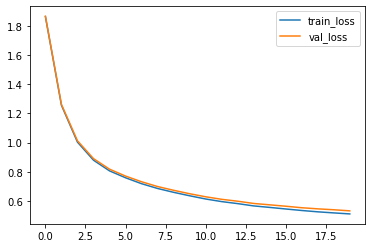

In [ ]:
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.show()

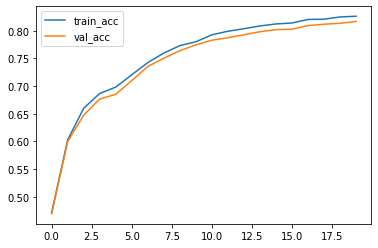

In [ ]:
plt.plot(accuracies, label="train_acc")
plt.plot(val_accuracies, label="val_acc")
plt.legend()
plt.show()

## Compared results

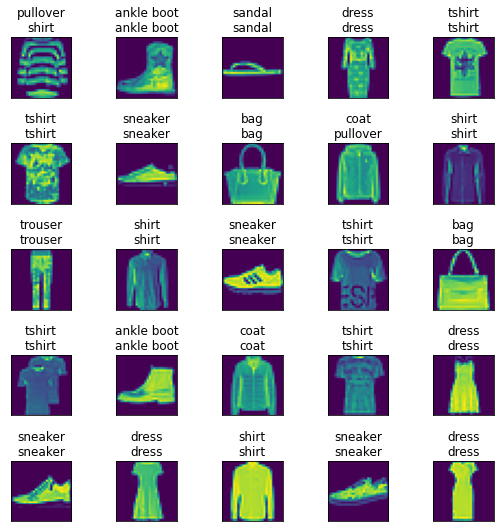

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=25, shuffle=True)))
pred = net(X).argmax(axis=1)
show_images(X.reshape(25, 28, 28), 5, 5, 
            titles=list([i+"\n"+j for i, j in zip(get_fmnist_labels(y),get_fmnist_labels(pred))])
)
plt.show()